### Laboratory work 5 - Tracking of a moving object which trajectory is disturbed by random acceleration
#### Abramov Semen, Belikov Ilia, Nikolay Zherdev, Mikhail Kulbeda
#### Skoltech, 11.10.2018

The objective of this laboratory work is to develop standard Kalman filter for tracking a moving object which trajectory is disturbed by random acceleration. Important outcome of this exercise is getting deeper understanding of Kalman filter parameters and their role in estimation. Students will analyze the sensitivity of estimations to choice of non-optimal parameters and dependence on initial conditions.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error


init_notebook_mode(connected=True)

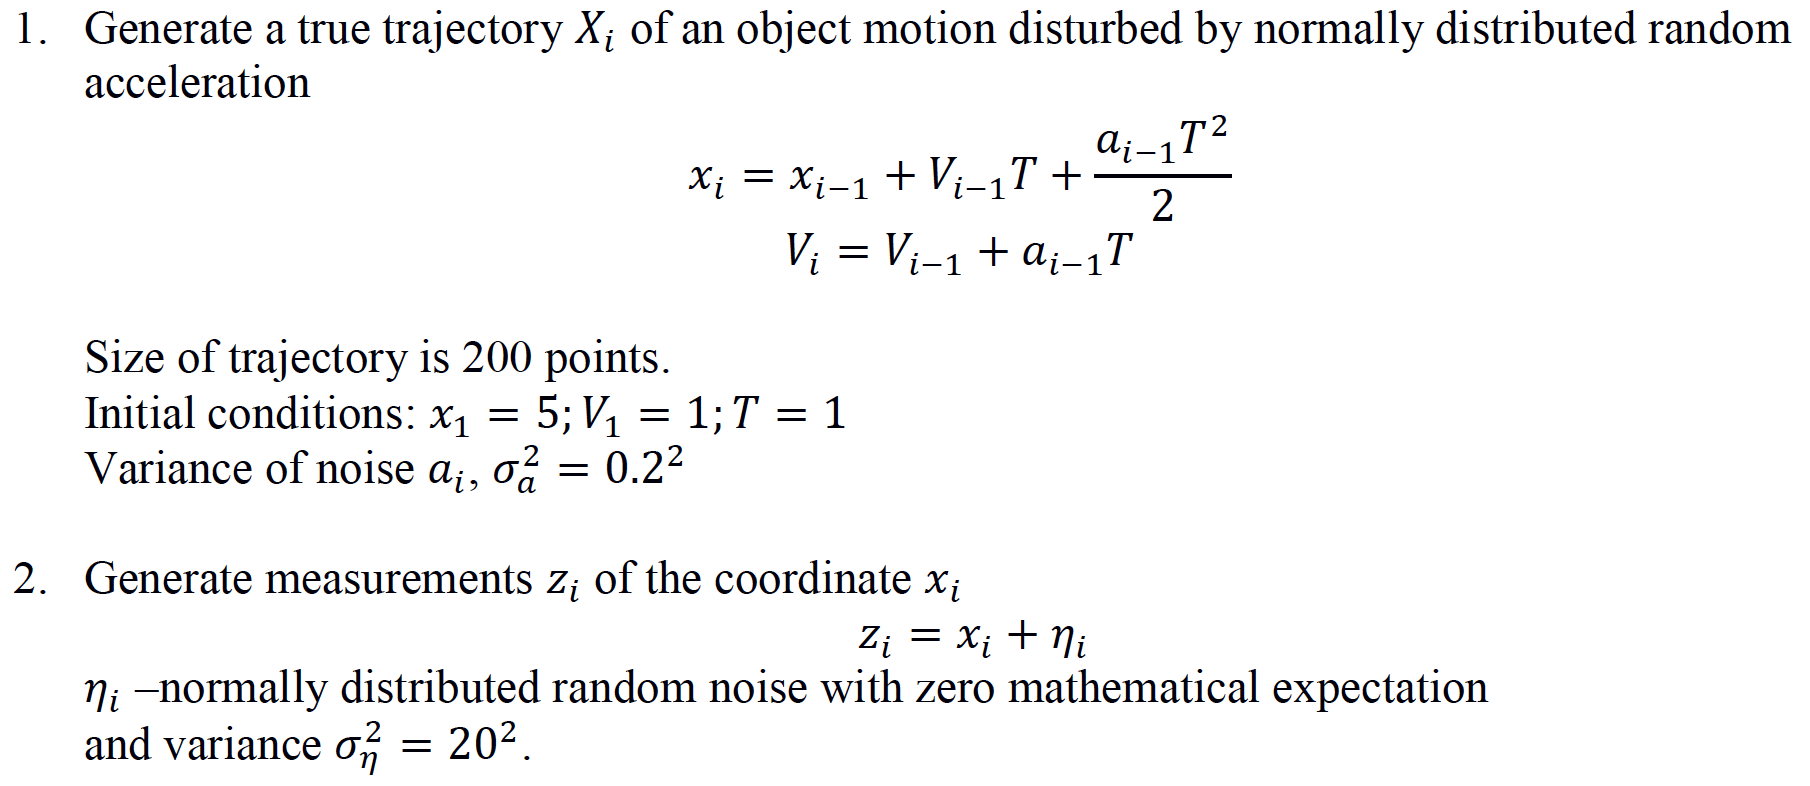

In [2]:
# Accelerated motion
def generate_trajectory(X0 = 5, V0 = 0, T = 0.1, mean = 0, var = 0.1, steps = 300):

    velocity = np.zeros(steps)
    velocity[0] = V0
    accels = np.random.normal(loc = mean, scale = np.sqrt(var), size = steps)
    velocity[1:] = accels[:-1]*T
    velocity = np.cumsum(velocity)
    
    X = np.zeros(steps)
    X[0] = X0
    X[1:] = velocity[:-1]*T + accels[:-1]*(T**2)/2
    return np.cumsum(X)

In [3]:
def measure(trajectory, mean = 0, var = 0.1):
    noise = np.random.normal(loc = mean, scale = np.sqrt(var), size = trajectory.shape)
    return np.add(trajectory, noise)

In [4]:
tr = generate_trajectory(X0 = 5, V0 = 1, T = 1, mean = 0, var = 0.2**2, steps = 200)
measurments = measure(tr, var = 20**2) # array Nx1

In [5]:
data = [
    go.Scatter(
        y=tr,
        name='Accellerated Motion'
    ),
    go.Scatter(
        y=measurments,
        name='Accel Motion Measurments'
    ),   
]

layout= go.Layout(
    title= 'Accellerated Motion and Accel Motion Measurments',
    xaxis= dict(
        title= 'Steps',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

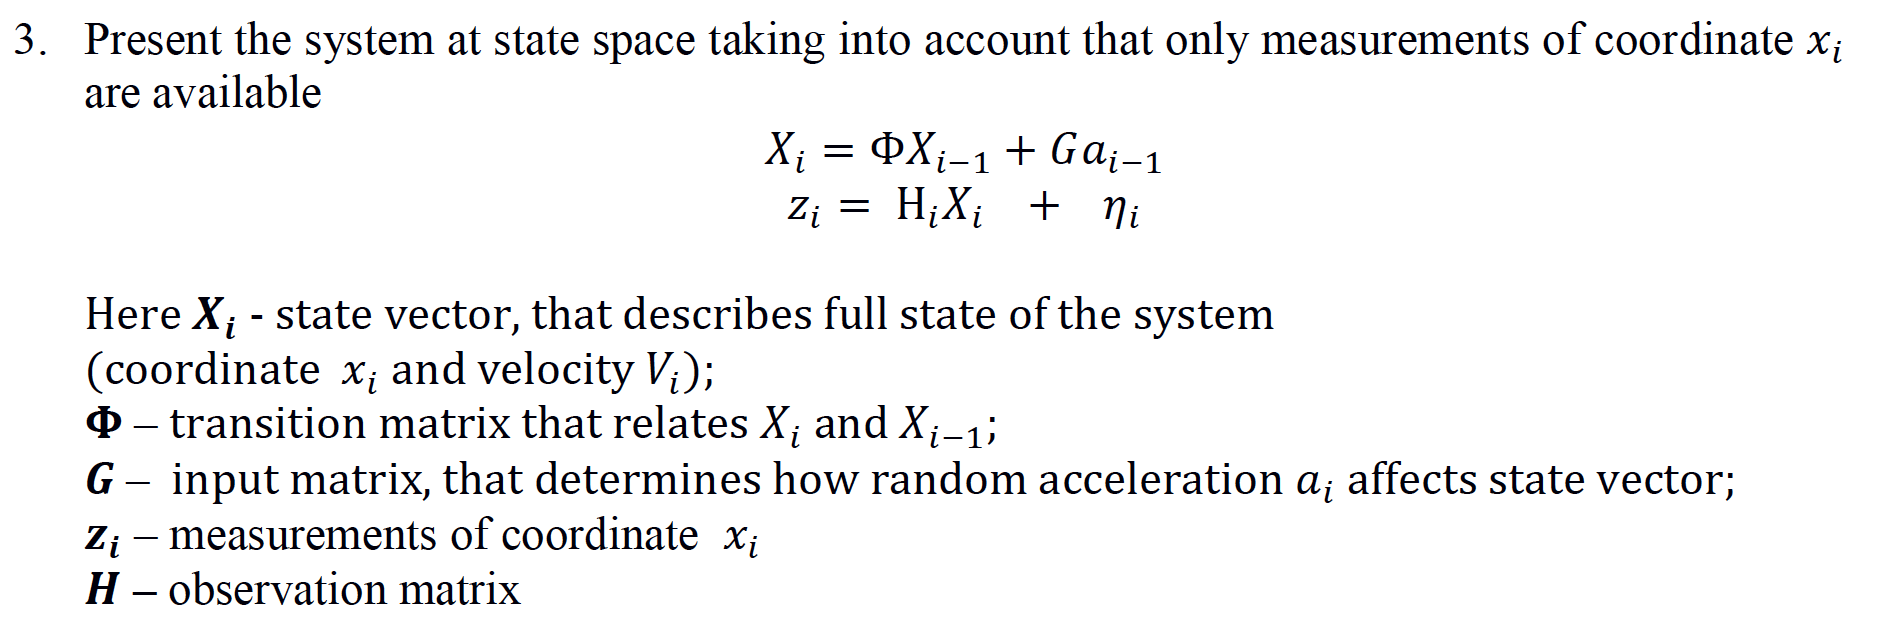

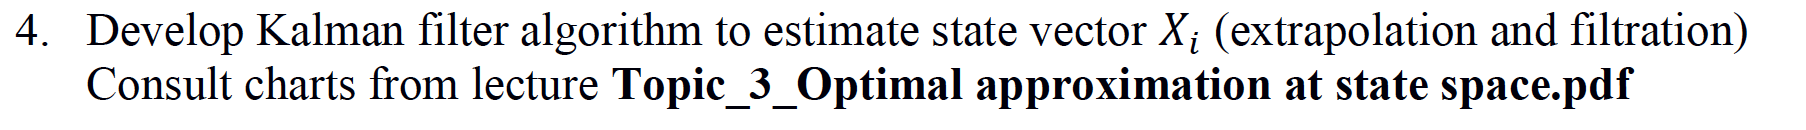
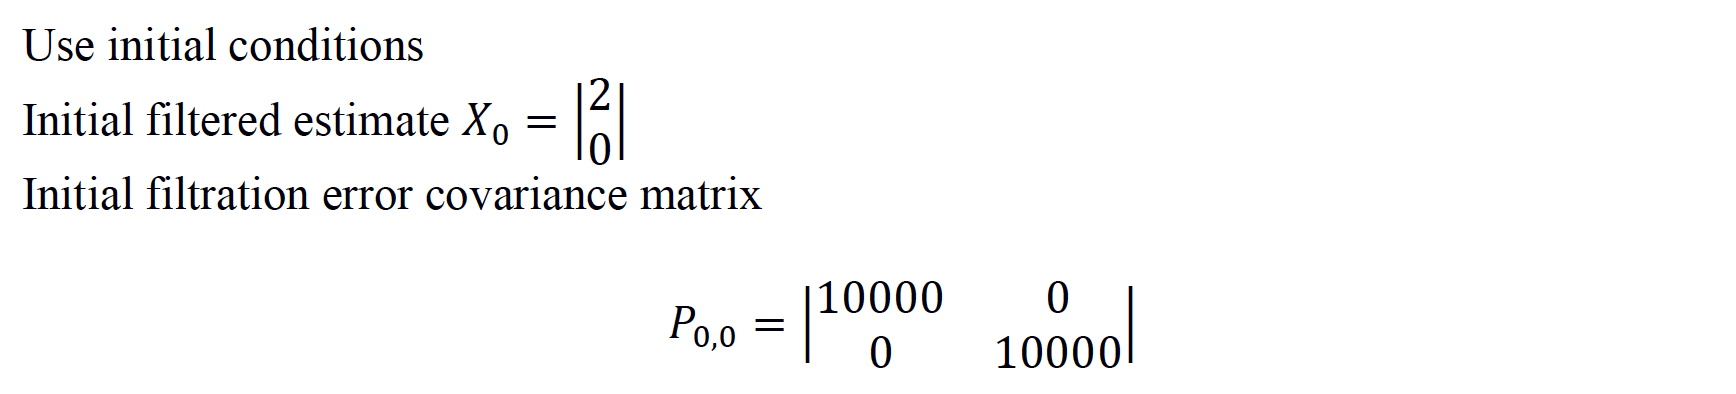


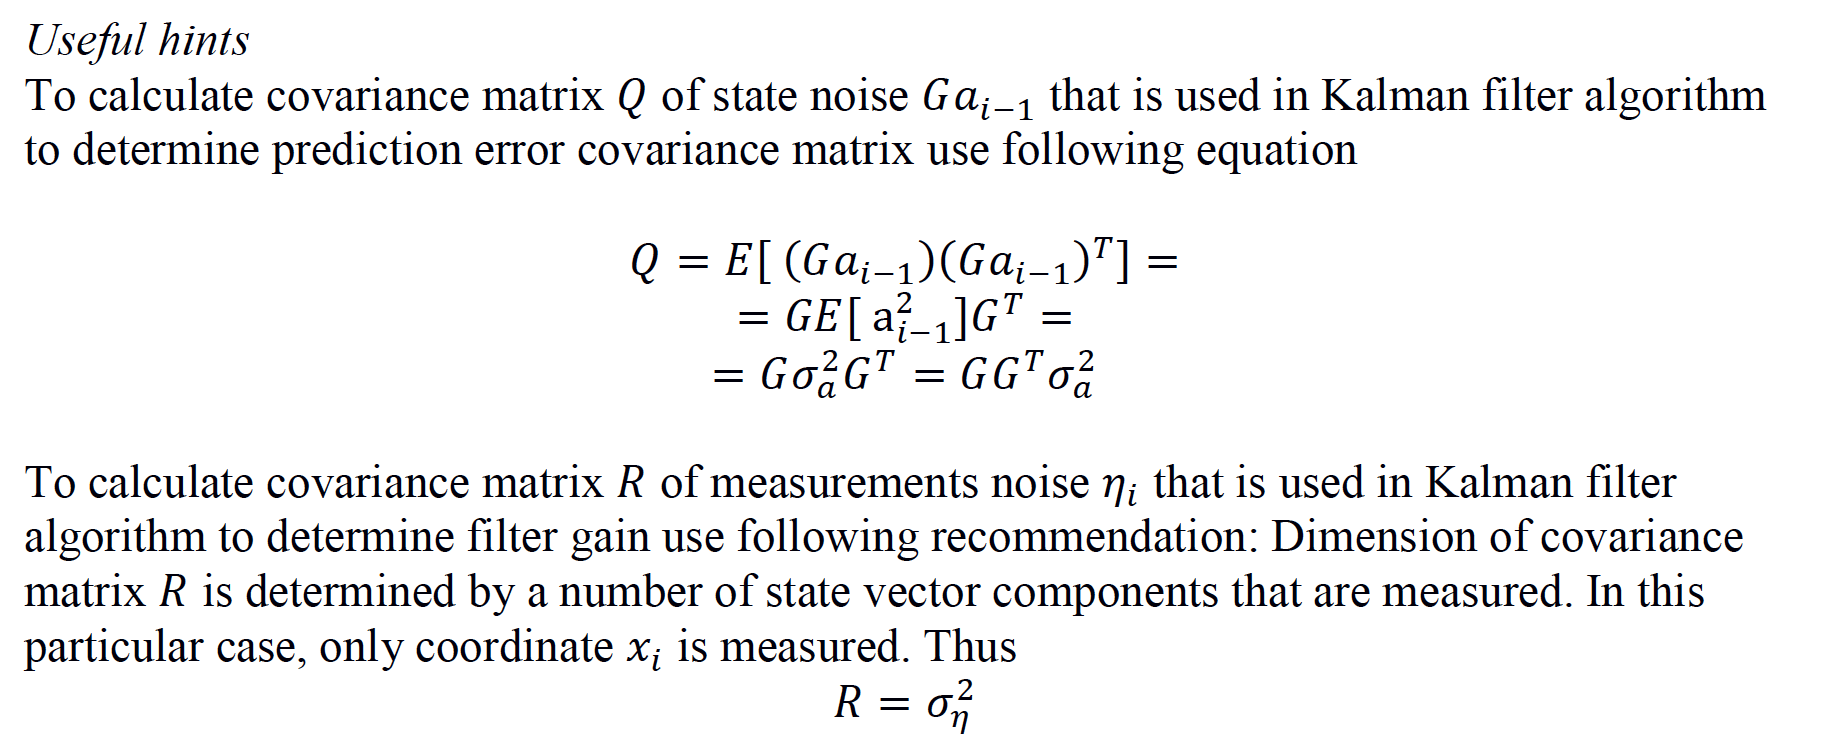

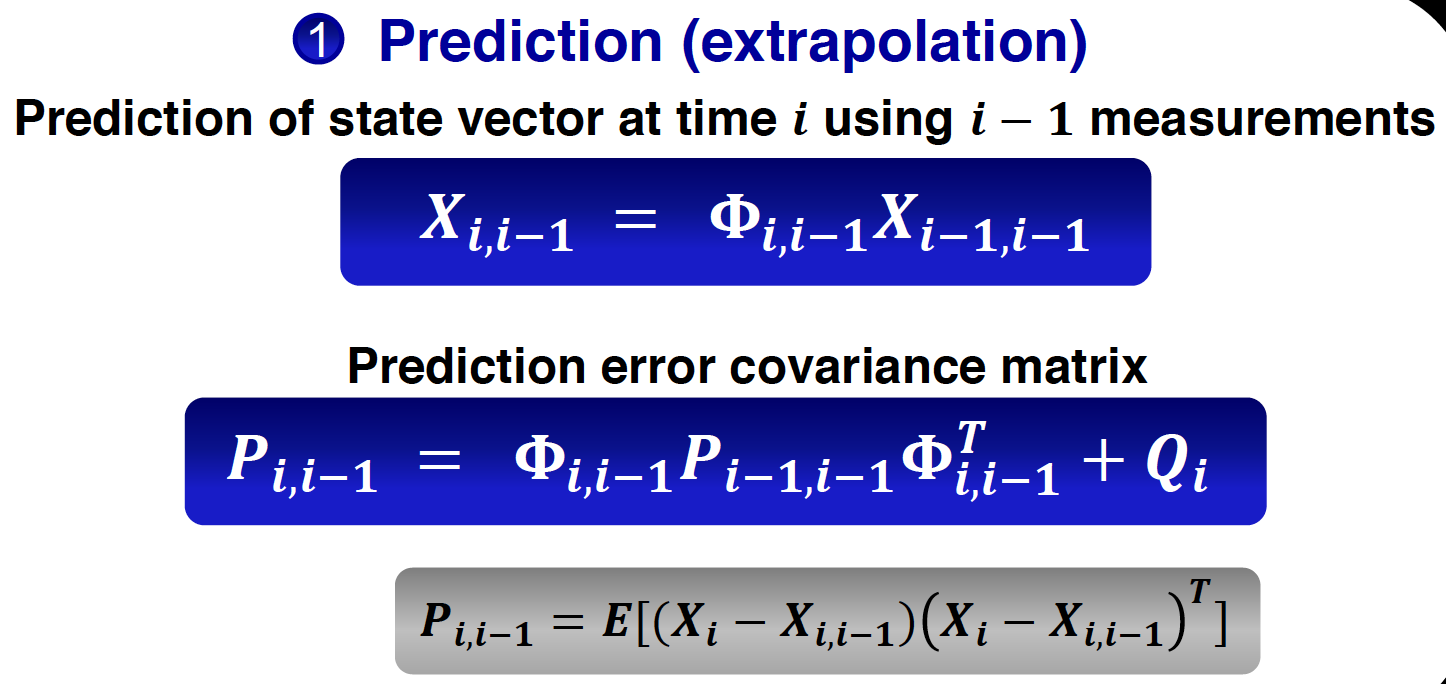


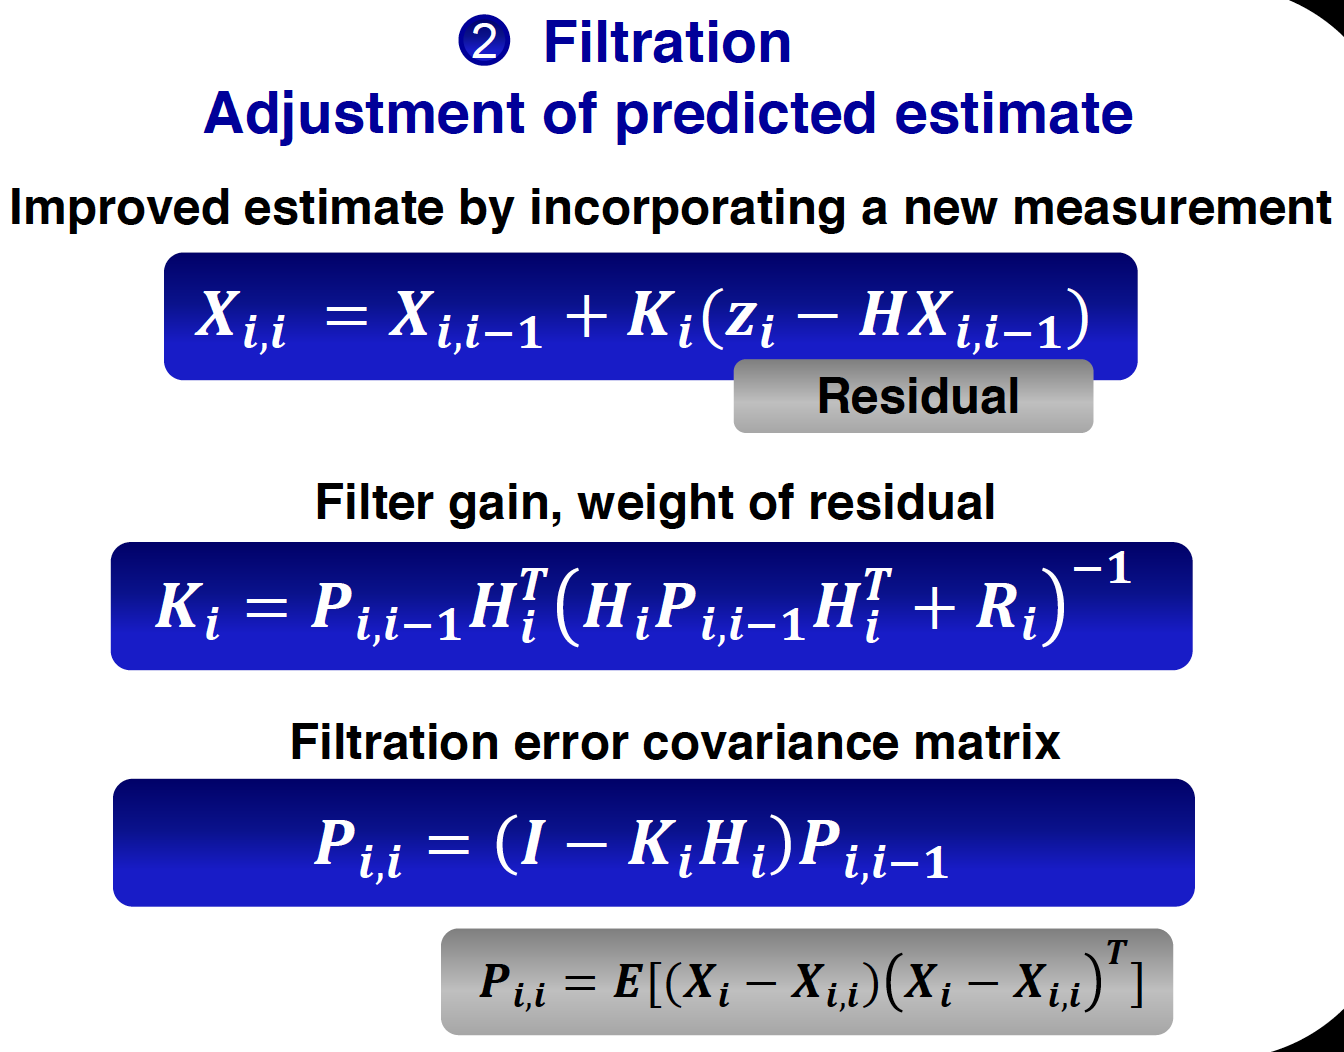

In [6]:
def kalman(measr, T = 1, X_init = [2.0, 0], P_init = [[10000, 0], [0, 10000]], var_a = 0.2**2, var_n = 20**2):
    
    size = (len(measr), 2) # size of array
    G = np.array([T**2/2, T]).T
    Q = G.dot(G.T.dot(var_a))
    R = var_n
    F = np.array([[1, T], [0, 1]])
    H = np.array([1, 0])
    X = np.zeros(size)
    X_ = np.zeros(size)
    P = np.zeros((size[0], 2, 2))
    P_ = np.zeros((size[0], 2, 2))
    K = np.zeros(size) 
    
    X_[0] = X_init
    P_[0] = P_init
    
    for k in range(1, size[0]):
        
        # Prediction
        X[k] = np.dot(F, X_[k-1])
        P[k] = np.dot(F, np.dot(P_[k-1], F.T)) + Q
        
        # Update
        K[k] = np.dot(P[k], H.T)/(np.dot(H, np.dot(P[k], H.T)) + R)
        X_[k] = X[k] + K[k]*(measr[k] -  np.dot(H, X[k]))
        P_[k] = np.dot((np.eye(2) - np.outer(K[k], H)), P[k])   
    
    return X[:,0], X_[:,0], K[:,0], np.sqrt(P[:,0,0]), np.sqrt(P_[:,0,0]), np.linalg.matrix_power(F,7).dot(X_.T)[0]

In [7]:
X_predicted, X_filtered, K, P_predicted, P_filtered, X7 = kalman(measurments)

## 5

In [8]:
data = [
    go.Scatter(
        y = tr,
        name='true trajectory'
    ),
    go.Scatter(
        y = measurments,
        name='measurement'
    ),
    go.Scatter(
        y = kalman(measurments)[0],
        name='Kalman estimation'
    ),
    go.Scatter(
        y = kalman(measurments)[5],
        name='Kalman 7 steps extrapolation'
    ),
]

layout= go.Layout(
    title= 'Kalman filtering',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

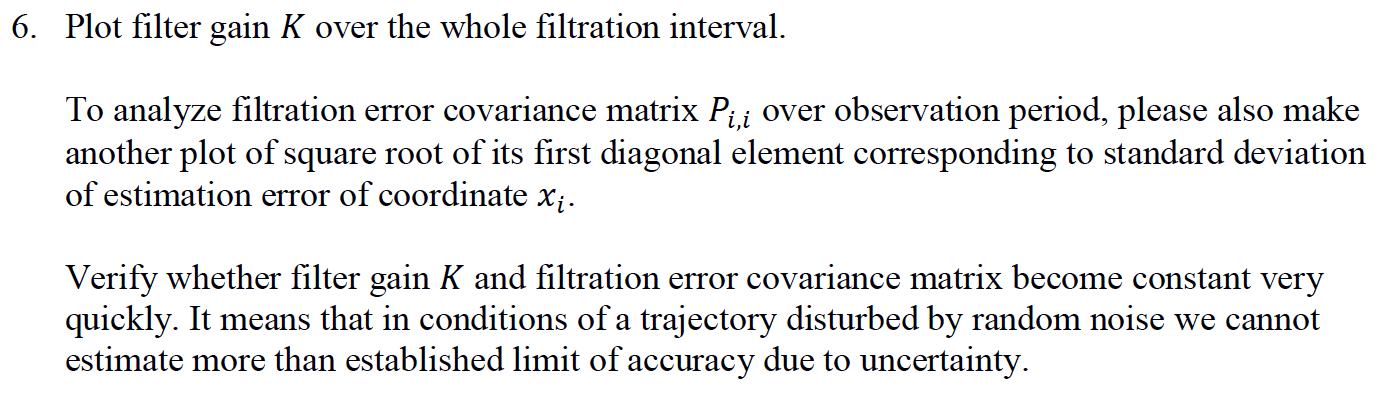

In [9]:
data = [
    go.Scatter(
        y = kalman(measurments)[2],
        name='Kalman gain'
    ),
    go.Scatter(
        y=kalman(measurments)[4],
        name='std of estim error of coord x'
    ),
]

layout= go.Layout(
    title= 'Kalman gain',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

Filter gain 𝐾 and filtration error covariance matrix become constant very quickly. It means that in conditions of a trajectory disturbed by random noise we cannot estimate more than established limit of accuracy due to uncertainty

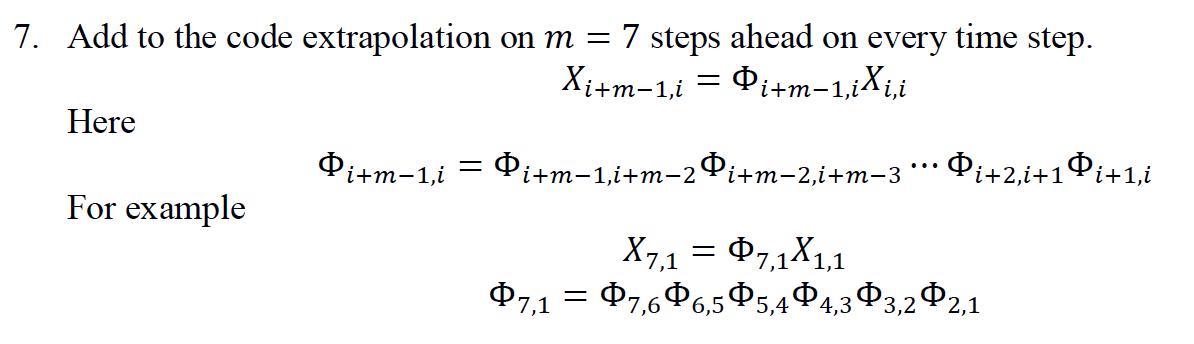

done, please see above

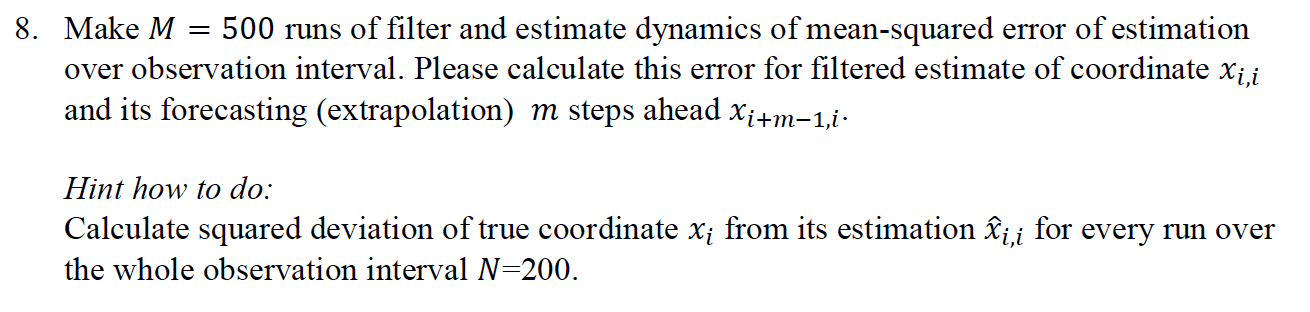

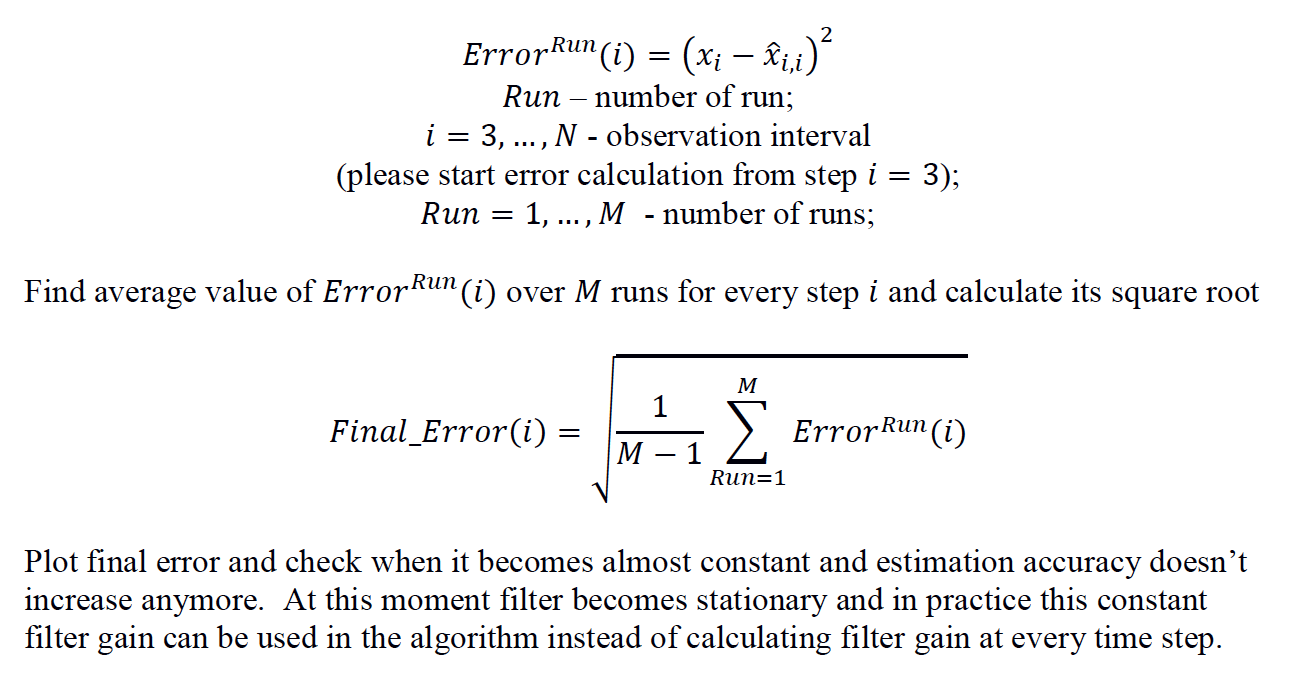

In [10]:
def experiment(runs = 500, steps = 200, P_init = [[10000, 0], [0, 10000]], X_init = [2.0, 0], var_a = 0.2**2, var_n = 20**2):
    error_e = np.zeros(steps)
    error_f = np.zeros(steps)
    
    for i in range(runs):
        
        tr = generate_trajectory(X0 = 5, V0 = 1, T = 1, mean = 0, var = var_a, steps = steps)
        measurments = measure(tr, var = var_n)
        X_predicted, X_filtered, K, P_predicted, P_filtered, X7 = kalman(measurments, P_init = P_init, var_a = var_a)
        
        error_e += (X_predicted - tr)**2
        error_f += (X7 - tr)**2
        
    error_e = np.sqrt(error_e/(runs-1))
    error_f = np.sqrt(error_f/(runs-1))

    return error_e, error_f

In [11]:
error_e, error_f = experiment()

In [12]:
data = [
    go.Scatter(
        y=error_e[2:],
        name='mse of estimation'
    ),
    go.Scatter(
        y=error_f[2:],
        name='mse of forecasting'
    ),
]

layout= go.Layout(
    title= 'Mean error of estimation by step',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

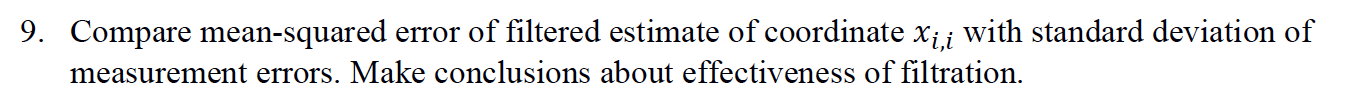

Standart deviation of measurment errors is sqrt(var_n = 20**2) = 20. And MSE of filtered estimate is perturbating around value 8. Filtration is effective.

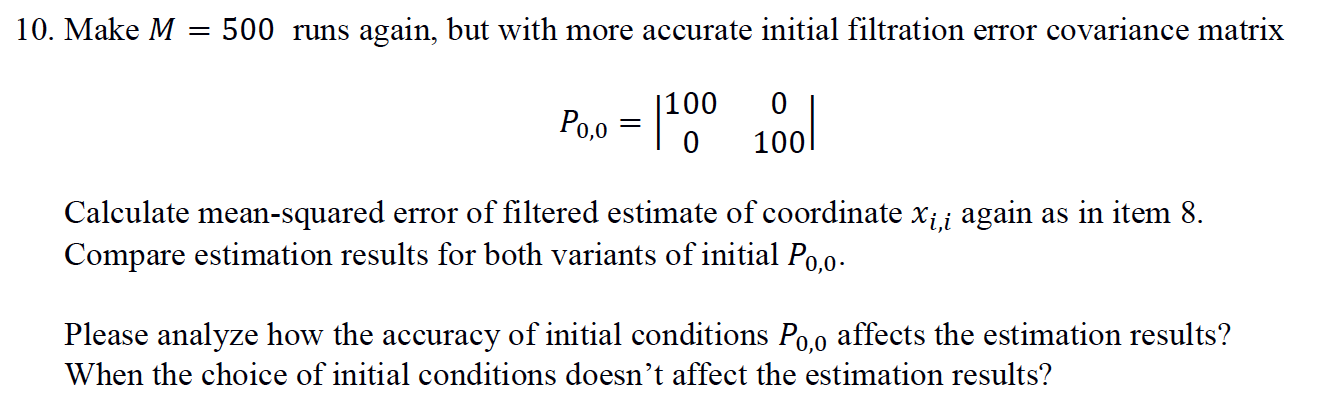

In [13]:
error_e_acc, error_f_acc = experiment(P_init = [[100, 0], [0, 100]])

With more accurate covariance matrix P MSE of estimations faster reach stable value.

In [14]:
data = [
    go.Scatter(
        y=error_e[2:],
        name='high P'
    ),
    go.Scatter(
        y=error_e_acc[2:],
        name='low P'
    ),
]

layout= go.Layout(
    title= 'Mean error of estimation by step',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

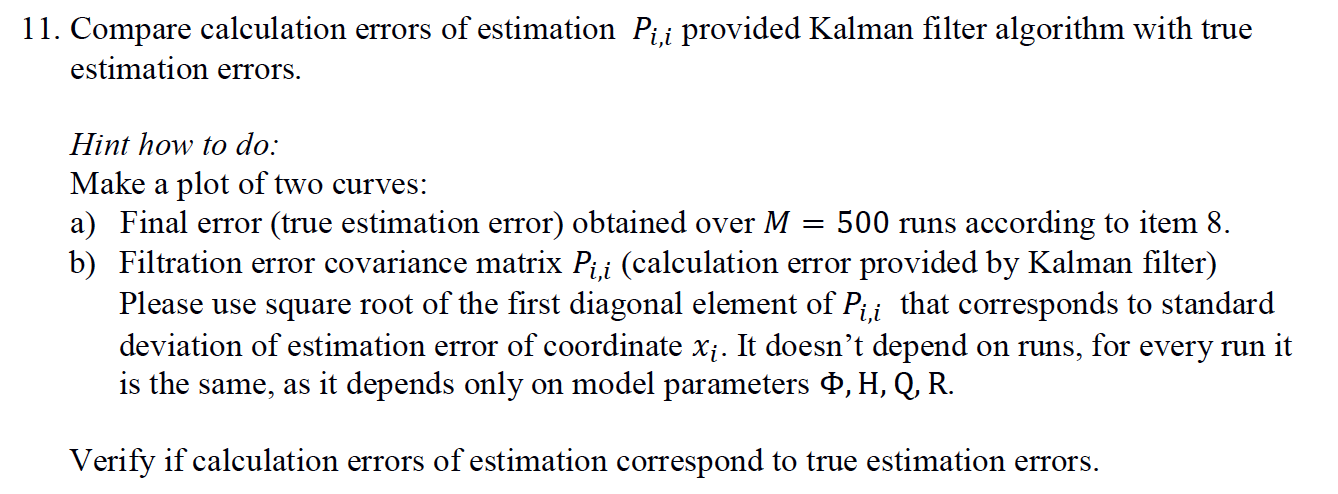

In [15]:
X_predicted, X_filtered, K, P_predicted, P_filtered, X7 = kalman(measurments)

square root of the first diagonal element of 𝑃𝑖,𝑖 corresponds to standard deviation of estimation error of coordinate 𝑥𝑖.

In [16]:
data = [
    go.Scatter(
        y=error_e,
        name='true estimation error'
    ),
    go.Scatter(
        y=P_filtered,
        name='filtration error cov matr P'
    ),
]

layout= go.Layout(
    title= 'Mean error of estimation by step',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

Calculation errors of estimation correspond to true estimation errors.

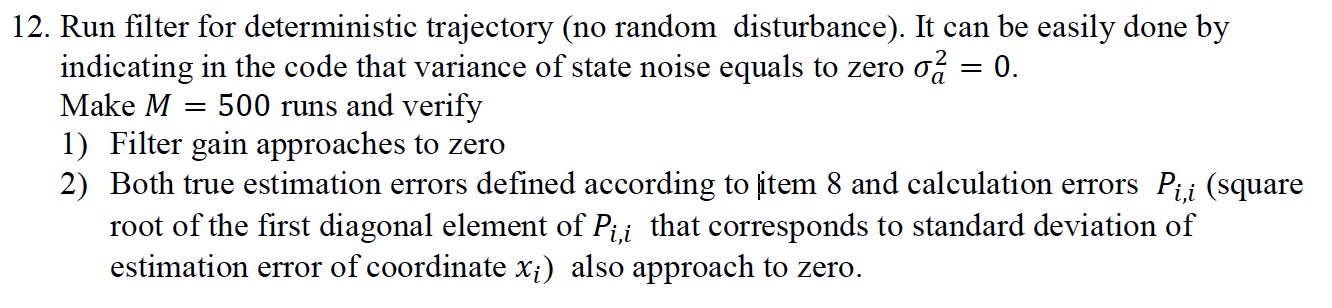

In [17]:
tr = generate_trajectory(X0 = 5, V0 = 1, T = 1, mean = 0, var = 0, steps = 200)
measurments = measure(tr, var = 20**2) # array Nx1

X_predicted, X_filtered, K, P_predicted, P_filtered, X7 = kalman(measurments, var_a = 0)

error_e, error_f = experiment(var_a = 0)

In [18]:
data = [
    go.Scatter(
        y=X_filtered,
        name='Kalman filtered'
    ),
    go.Scatter(
        y=tr,
        name='true trajectory'
    ),
    go.Scatter(
        y=P_filtered,
        name='filtration error cov matr P'
    ),
    go.Scatter(
        y=K,
        name='filter gain'
    ),
    go.Scatter(
        y=error_e,
        name='estimation error'
    ),
]

layout= go.Layout(
    title= 'Mean error of estimation by step',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

All three parameters indeed are approaching zero

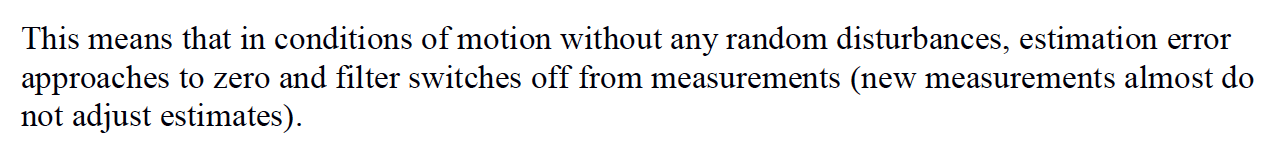

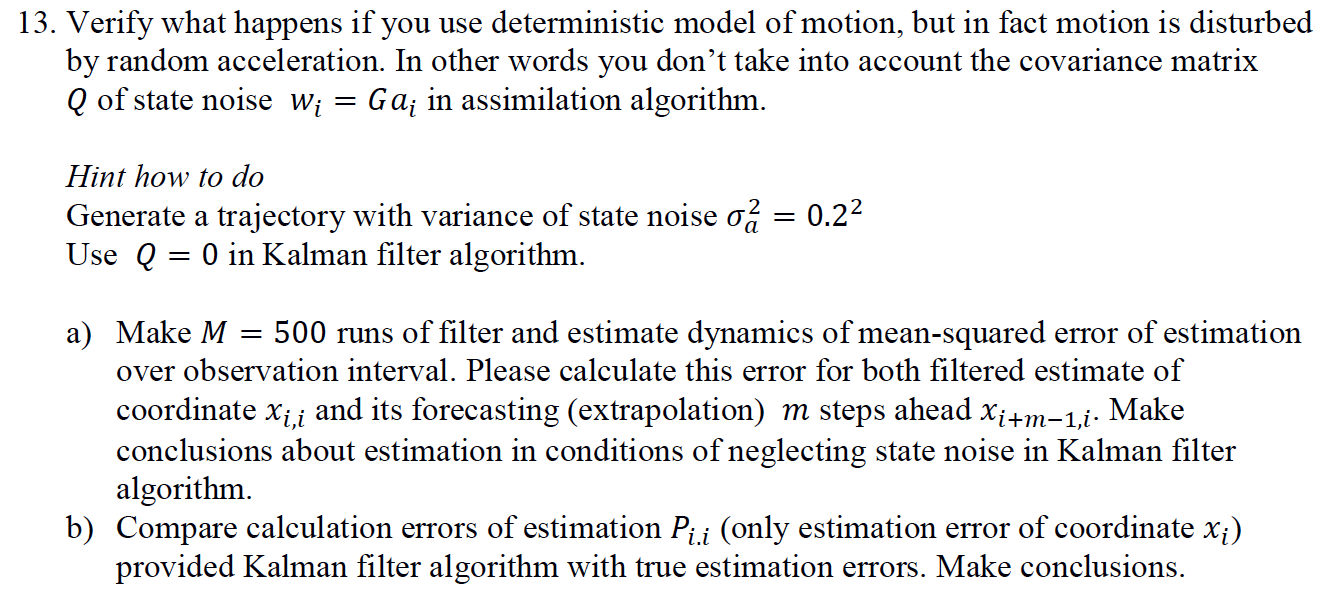

In [19]:
G = np.array([0, 0]).T
Q = G.dot(G.T.dot(0))
Q

0

In [20]:
def experiment2(runs = 500, steps = 200, P_init = [[10000, 0], [0, 10000]], X_init = [2.0, 0], var_a = 0.2**2, var_n = 20**2):
    error_e = np.zeros(steps)
    error_f = np.zeros(steps)
    
    for i in range(runs):
        
        tr = generate_trajectory(X0 = 5, V0 = 1, T = 1, mean = 0, var = var_a, steps = steps)
        measurments = measure(tr, var = var_n)
        X_predicted, X_filtered, K, P_predicted, P_filtered, X7 = kalman(measurments, T = 0, P_init = P_init, var_a = 0)
        
        error_e += (X_predicted - tr)**2
        error_f += (X7 - tr)**2
        
    error_e = np.sqrt(error_e/(runs-1))
    error_f = np.sqrt(error_f/(runs-1))

    return error_e, error_f

In [21]:
error_e, error_f = experiment2()

In [22]:
data = [
    go.Scatter(
        y=P_filtered,
        name='filtration error cov matr P'
    ),
    go.Scatter(
        y=error_e,
        name='estimation error'
    ),
    go.Scatter(
        y=error_f,
        name='mse of forecasting'
    ),
]

layout= go.Layout(
    title= 'Mean error of estimation by step',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

Estimation in conditions of neglecting state noise in Kalman filter algorithm leads to divergence. According to covariance matrix P, variance of coord xi approaches zero

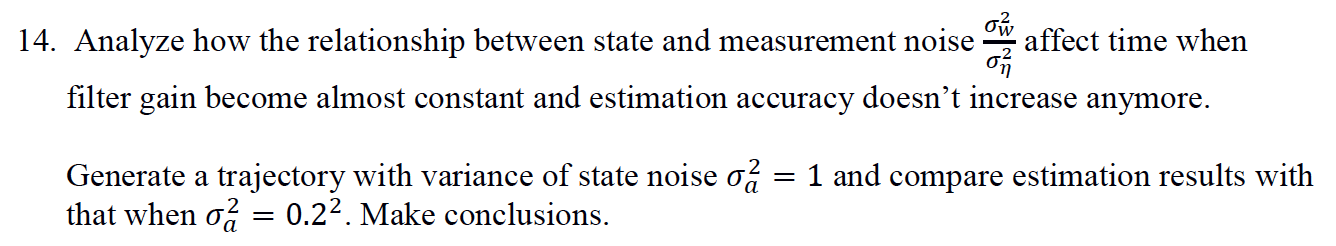

In [23]:
tr1 = generate_trajectory(X0 = 5, V0 = 1, T = 1, mean = 0, var = 1, steps = 200)
measurments1 = measure(tr1, var = 20**2) # array Nx1
_, _, K1, _, _, _ = kalman(measurments1, var_a = 1)


tr = generate_trajectory(X0 = 5, V0 = 1, T = 1, mean = 0, var = 0.2**2, steps = 200)
measurments = measure(tr, var = 20**2) # array Nx1
_, _, K, _, _, _ = kalman(measurments, var_a = 0.2**2)


In [32]:
data = [
    go.Scatter(
        y=K1,
        name='var_state = 1'
    ),
    go.Scatter(
        y=K,
        name='var_state = 0.2**2'
    ),
]

layout= go.Layout(
    title= 'Mean error of estimation by step',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

With bigger variance of state noise Kalman gain becomes constant a little bit earlier. Why? That's an open question.

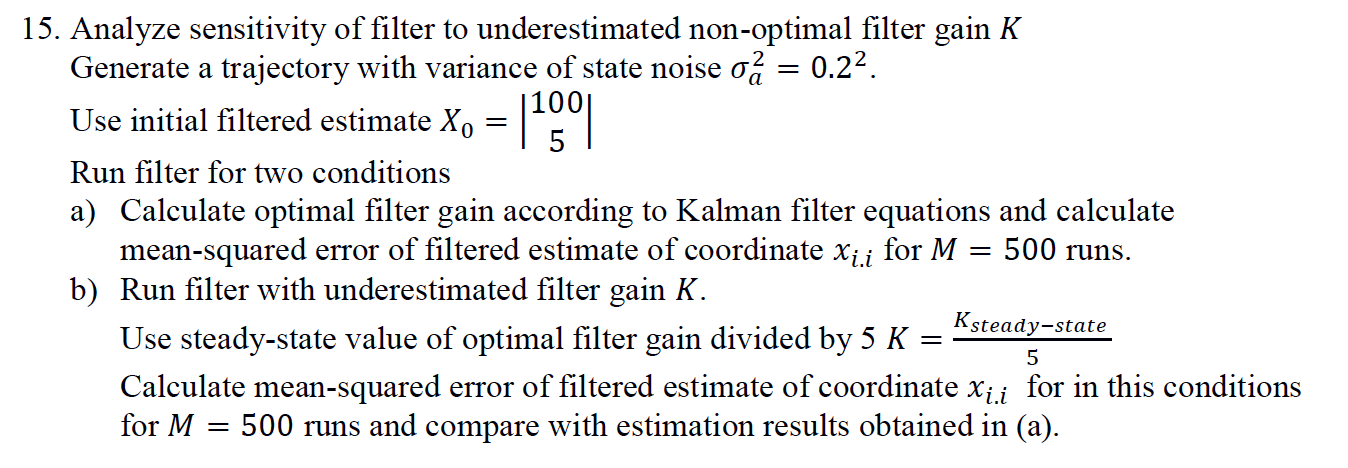

In [25]:
tr = generate_trajectory(X0 = 5, V0 = 1, T = 1, mean = 0, var = 0.2**2, steps = 200)
measurments = measure(tr, var = 20**2) # array Nx1
X_predicted, X_filtered, K, P_predicted, P_filtered, X7 = kalman(measurments, X_init = [100.0, 5.0], var_a = 0.2**2)


In [26]:
K[-1]

0.13895150388783037

In [27]:
error_e, error_f = experiment()

In [28]:
def kalman_under(measr, T = 1, X_init = [2.0, 0], P_init = [[10000, 0], [0, 10000]], var_a = 0.2**2, var_n = 20**2):
    
    size = (len(measr), 2) # size of array
    G = np.array([T**2/2, T]).T
    Q = G.dot(G.T.dot(var_a))
    R = var_n
    F = np.array([[1, T], [0, 1]])
    H = np.array([1, 0])
    X = np.zeros(size)
    X_ = np.zeros(size)
    P = np.zeros((size[0], 2, 2))
    P_ = np.zeros((size[0], 2, 2))
    #K = np.zeros(size) 
    K_ = 0.139/5
    K = np.array([K_, 0.01])
    
    X_[0] = X_init
    P_[0] = P_init
    
    for k in range(1, size[0]):
        
        # Prediction
        X[k] = np.dot(F, X_[k-1])
        P[k] = np.dot(F, np.dot(P_[k-1], F.T)) + Q
        
        # Update
        #K = np.dot(P[k], H.T)/(np.dot(H, np.dot(P[k], H.T)) + R)
        X_[k] = X[k] + K*(measr[k] -  np.dot(H, X[k]))
        P_[k] = np.dot((np.eye(2) - np.outer(K, H)), P[k])   
    
    return X[:,0], X_[:,0], K, np.sqrt(P[:,0,0]), np.sqrt(P_[:,0,0]), np.linalg.matrix_power(F,7).dot(X_.T)[0]

In [29]:
def experiment3(runs = 500, steps = 200, P_init = [[10000, 0], [0, 10000]], X_init = [2.0, 0], var_a = 0.2**2, var_n = 20**2):
    error_e = np.zeros(steps)
    error_f = np.zeros(steps)
    
    for i in range(runs):
        
        tr = generate_trajectory(X0 = 5, V0 = 1, T = 1, mean = 0, var = var_a, steps = steps)
        measurments = measure(tr, var = var_n)
        X_predicted, X_filtered, K, P_predicted, P_filtered, X7 = kalman_under(measurments, X_init = [100.0, 5.0], var_a = 0.2**2)
        
        error_e += (X_predicted - tr)**2
        error_f += (X7 - tr)**2
        
    error_e = np.sqrt(error_e/(runs-1))
    error_f = np.sqrt(error_f/(runs-1))

    return error_e, error_f

In [30]:
error_e_under, error_f_under = experiment3()

/Users/nickzherdev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning:

invalid value encountered in sqrt



In [31]:
data = [
    go.Scatter(
        y=error_e,
        name='error with optimal Kalman gain'
    ),
    go.Scatter(
        y=error_e_under,
        name='error with underestimated Kalman gain'
    ),
]

layout= go.Layout(
    title= 'Mean error of estimation by step',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

### Conclusions

Kalman filter provides estimates of variable parameters (x, V), when LSM – of constant
variables. It is sensitive to estimation of optimal filter gain.